In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cuda')

In [3]:
model = models.resnet152(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(512, 10)
)

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 156MB/s]


In [4]:
# data loading

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet mean
                         [0.229, 0.224, 0.225])  # ImageNet std
])


train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


train_len = int(0.9 * len(train_dataset))
val_len = len(train_dataset) - train_len
train_data, val_data = random_split(train_dataset, [train_len, val_len])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 170M/170M [00:18<00:00, 9.21MB/s]


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [6]:
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def validate(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

In [7]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_acc = 0.0
patience = 2           # number of epochs to wait for improvement
counter = 0            # counts epochs with no improvement
best_model_path = 'resnet152-cifar10.pth'


for epoch in range(5):
    train_loss, train_acc = train(model, train_loader, optimizer)
    val_loss, val_acc = validate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch+1} with Val Acc: {val_acc:.4f}")
    else:
        counter += 1
        print(f"No improvement for {counter} epoch(s)")

    # Early stopping condition
    if counter >= patience:
        print(f"Early stopping triggered after {patience} epochs without improvement.")
        break

Epoch 1: Train Acc=0.7991, Val Acc=0.8296
Best model saved at epoch 1 with Val Acc: 0.8296
Epoch 2: Train Acc=0.8268, Val Acc=0.8430
Best model saved at epoch 2 with Val Acc: 0.8430
Epoch 3: Train Acc=0.8379, Val Acc=0.8558
Best model saved at epoch 3 with Val Acc: 0.8558
Epoch 4: Train Acc=0.8458, Val Acc=0.8554
No improvement for 1 epoch(s)
Epoch 5: Train Acc=0.8509, Val Acc=0.8608
Best model saved at epoch 5 with Val Acc: 0.8608


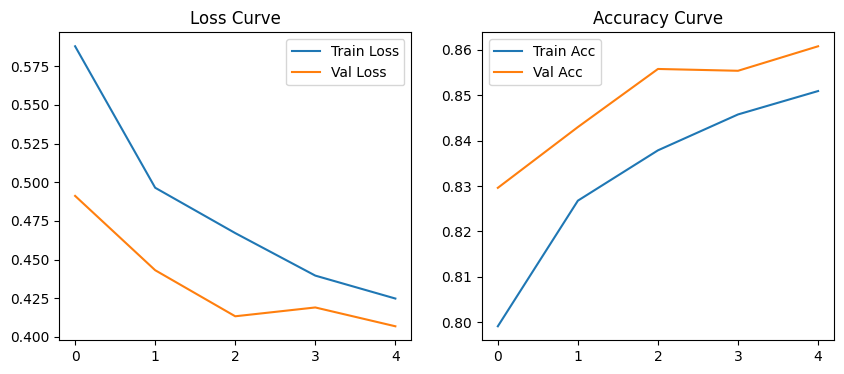

In [8]:
# loss curves

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")
plt.show()


In [11]:
model.eval()
y_true, y_pred, y_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        y_probs.extend(probs.cpu().numpy())
        preds = probs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

              precision    recall  f1-score   support

    airplane       0.85      0.85      0.85      1000
  automobile       0.89      0.92      0.90      1000
        bird       0.89      0.79      0.84      1000
         cat       0.74      0.74      0.74      1000
        deer       0.83      0.83      0.83      1000
         dog       0.80      0.84      0.82      1000
        frog       0.90      0.92      0.91      1000
       horse       0.90      0.85      0.87      1000
        ship       0.89      0.89      0.89      1000
       truck       0.88      0.91      0.89      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



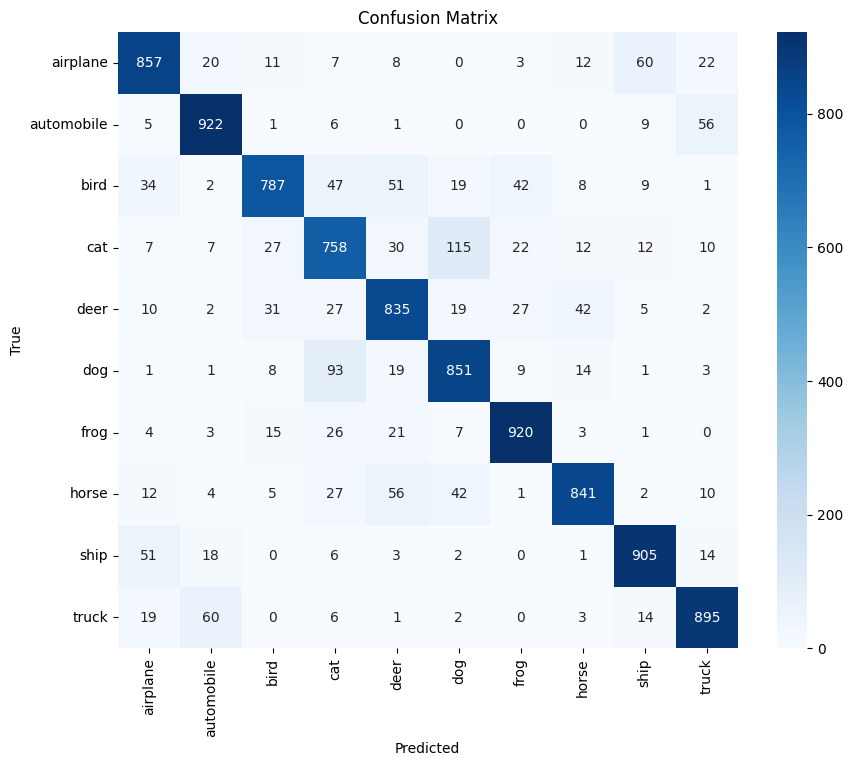

In [10]:
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()


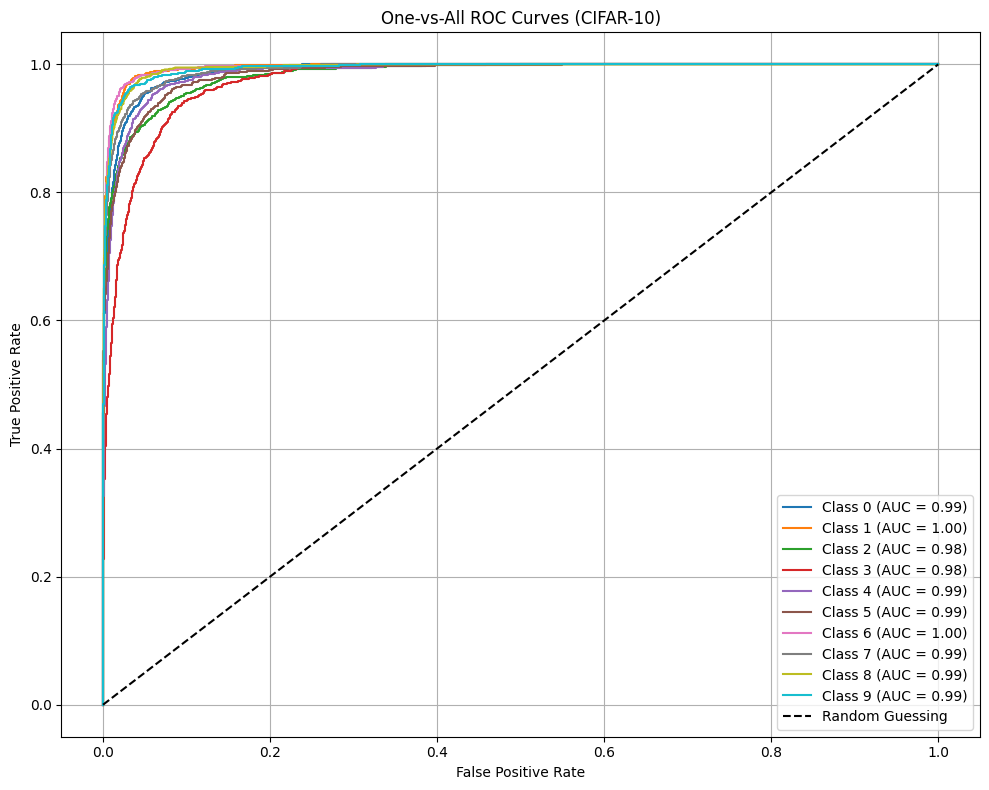

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

n_classes = 10

# Binarize labels
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))  # shape: (N, 10)
y_probs = np.array(y_probs)  # shape: (N, 10)


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-All ROC Curves (CIFAR-10)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
torch.save({
    'epoch': 5,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accs': train_accs,
    'val_accs': val_accs,
}, 'checkpoint.pth')

In [15]:
checkpoint = torch.load('checkpoint.pth')

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

start_epoch = checkpoint['epoch']
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
train_accs = checkpoint['train_accs']
val_accs = checkpoint['val_accs']

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
best_val_acc = 0.0
patience = 2           # number of epochs to wait for improvement
counter = 0            # counts epochs with no improvement
best_model_path = 'resnet152-cifar10-new.pth'

for epoch in range(start_epoch + 1, 11):  # 6 to 10
    train_loss, train_acc = train(model, train_loader, optimizer)
    val_loss, val_acc = validate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch+1} with Val Acc: {val_acc:.4f}")
    else:
        counter += 1
        print(f"No improvement for {counter} epoch(s)")

    # Early stopping condition
    if counter >= patience:
        print(f"Early stopping triggered after {patience} epochs without improvement.")
        break

Epoch 6: Train Acc=0.8592, Val Acc=0.8650
Best model saved at epoch 7 with Val Acc: 0.8650
Epoch 7: Train Acc=0.8602, Val Acc=0.8690
Best model saved at epoch 8 with Val Acc: 0.8690
Epoch 8: Train Acc=0.8653, Val Acc=0.8684
No improvement for 1 epoch(s)
Epoch 9: Train Acc=0.8674, Val Acc=0.8698
Best model saved at epoch 10 with Val Acc: 0.8698
Epoch 10: Train Acc=0.8737, Val Acc=0.8648
No improvement for 1 epoch(s)
